<a href="https://colab.research.google.com/github/RohanSaxena14/social_distance_tracker/blob/master/social_distancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Social Distance Tracker**



#since we will be using yolov3 in openCV, in this block we have downloaded the weights of a pretrained model.
#But you still have to upload the "yolo.cfg" and "coco.names" files in the runtime, do not worry i have included them in the yolov3 directory.

In [0]:
!wget https://pjreddie.com/media/files/yolov3.weights

# **We have imported all the necessary packages and set-up the Darknet in openCV**
#**The coco dataset has 80 categories in it**

In [1]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

net = cv.dnn.readNetFromDarknet("yolov3.cfg", "yolov3.weights")

classes = []


with open("coco.names") as f:
    classes = [line.strip() for line in f.readlines()]

print("classes", classes)

name = net.getLayerNames()
out = net.getUnconnectedOutLayers()

outputlayernames = [name[i[0] - 1] for i in out]

classes ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


'\nname = net.getLayerNames()\nout = net.getUnconnectedOutLayers()\n\noutputlayernames = [name[i[0] - 1] for i in out]'

# **This function takes in the image and using yolov3 pretrained model, tells us where the pedestrians are in the image**

In [0]:
def post_process(img):
    (H, W) = img.shape[:2]
    blob = cv.dnn.blobFromImage(img, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    output = net.forward(outputlayernames)
    boxes, confidences, class_ids = [], [], []
    height, width, shape = img.shape
    for o in output:
        for detection in o:
            # print(len(detection))
            scores = detection[5:]
            class_ids = np.argmax(scores)
            confidence = scores[class_ids]
            if confidence > 0.6 and class_ids == 0:
                # print("detection", detection)
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))

    return boxes, confidences, class_ids

#**After detecting the pedestrains we have to see if they maintain a proper distance between them, All the defaulties will be highlighted using red boxes**

In [0]:
def green_boxes():
    rb = []
    for i in range(len(boxes)):
        if i in indexes:
            a, b, c, d = boxes[i]
            cv.rectangle(img, (a, b), (c + a, d + b), (0, 255, 0), 2)
            rb.append([a, b, c, d])
    return rb


def red_boxes(rb):
    red_boxes = []
    for f in range(len(rb)):
        for j in range(len(rb)):
            if j == f:
                break
            else:
                x1, y1 = rb[f][:2]
                x2, y2 = rb[j][:2]
                dist = np.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))
                if dist <= 130:
                    red_boxes.append(rb[f])
                    red_boxes.append(rb[j])
    for r in red_boxes:
        A, B, C, D = r
        cv.putText(img, "ALERT", (int(A), int(B) - 5), font, 0.5, [0, 0, 255], 2)
        cv.rectangle(img, (A, B), (A + C, B + D), [0, 0, 255], 2)

    return

#**Use this block if you want to test the model on an image**

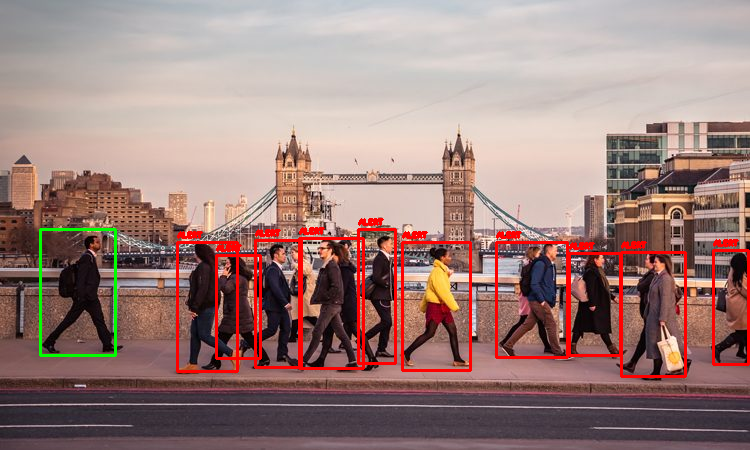

True

In [0]:
img = cv.imread("test_image.jpg", 1)

boxes, confidences, class_ids = post_process(img)
font = cv.FONT_HERSHEY_PLAIN
indexes = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.5)

rb = green_boxes()

red_boxes(rb)

cv2_imshow(img)
cv.imwrite("output.jpg",img)

#**Use this block you want to test it on a video**

In [0]:
cap = cv.VideoCapture("pedestrians.mp4")
_, frame = cap.read()

out = cv.VideoWriter('output.mp4',cv.VideoWriter_fourcc('M','J','P','G'), 10, (frame.shape[1],frame.shape[0]))


while cap.isOpened():
    ret, img = cap.read()
    if ret == False:
        continue
    boxes, confidences, class_ids = post_process(img)
    font = cv.FONT_HERSHEY_PLAIN
    indexes = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.5)

    rb = green_boxes()

    red_boxes(rb)

    cv2_imshow(img)
    out.write(img)
    if cv.waitKey(1) == ord("q"):
        break

cap.release()
out.release()